 # Modelo Swin

- Esse notebook tem a finalidade de oferecer uma implementação não modularizada da oferecida no diretório `./modeloSwin`

## Definição dos Imports

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim #importação da função de otimização
from torchvision.models import swin_t, Swin_T_Weights # import do modelo Swin Transformer Tiny Architecture e seu conjunto de pesos pré-treinados


## Definição dos DataLoaders

In [6]:
#ajuste dos diretórios
import os

current_directory = os.getcwd()

train_dir = os.path.join(current_directory, "drive/MyDrive/projetofinal_edl/PokemonSplit", "train")
test_dir = os.path.join(current_directory, "drive/MyDrive/projetofinal_edl/PokemonSplit", "test")
print(current_directory, train_dir,test_dir)


/content /content/drive/MyDrive/projetofinal_edl/PokemonSplit/train /content/drive/MyDrive/projetofinal_edl/PokemonSplit/test


In [9]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [13]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [14]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_loader, test_loader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_loader, test_loader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7da8b12fbcd0>,
 ['Abra',
  'Aerodactyl',
  'Alakazam',
  'Alolan Sandslash',
  'Arbok',
  'Arcanine',
  'Articuno',
  'Beedrill',
  'Bellsprout',
  'Blastoise',
  'Bulbasaur',
  'Butterfree',
  'Caterpie',
  'Chansey',
  'Charizard',
  'Charmander',
  'Charmeleon',
  'Clefable',
  'Clefairy',
  'Cloyster',
  'Cubone',
  'Dewgong',
  'Diglett',
  'Ditto',
  'Dodrio',
  'Doduo',
  'Dragonair',
  'Dragonite',
  'Dratini',
  'Drowzee',
  'Dugtrio',
  'Eevee',
  'Ekans',
  'Electabuzz',
  'Electrode',
  'Exeggcute',
  'Exeggutor',
  'Farfetchd',
  'Fearow',
  'Flareon',
  'Gastly',
  'Gengar',
  'Geodude',
  'Gloom',
  'Golbat',
  'Goldeen',
  'Golduck',
  'Golem',
  'Graveler',
  'Grimer',
  'Growlithe',
  'Gyarados',
  'Haunter',
  'Hitmonchan',
  'Hitmonlee',
  'Horsea',
  'Hypno',
  'Ivysaur',
  'Jigglypuff',
  'Jolteon',
  'Jynx',
  'Kabuto',
  'Kabutops',
  'Kadabra',
  'Kakuna',
  'Kangaskhan',
  'Kingler',
  'Koffing',
  'Krabby',
  'Lap

## Construção do Modelo

In [15]:
#criação da instância do modelo pré-treinado
model = swin_t(weights=Swin_T_Weights.DEFAULT)

#alteração da ultima camada de classificação para classificar de acordo com as classes do projeto
num_classes = 150
model.head = nn.Linear(model.head.in_features, num_classes)
print(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed



Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:03<00:00, 35.5MB/s]

150


## Loop de Treinamento

In [ ]:
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

resultado = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:  # Print every 100 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

    result = {
      'epoch': epoch,
      'train_loss': running_loss/len(train_loader),
      'val_loss': val_loss,
      'val_accuracy': val_accuracy
    }
    resultado.append(result)

print('Training complete')


Epoch [1/10], Step [100/169], Loss: 5.1040
Epoch [1/10], Loss: 5.0682
Validation Loss: 5.0437, Accuracy: 0.74%
Epoch [2/10], Step [100/169], Loss: 5.0054
Epoch [2/10], Loss: 5.0497
Validation Loss: 5.0391, Accuracy: 0.74%
Epoch [3/10], Step [100/169], Loss: 5.0346
Epoch [3/10], Loss: 5.0382
Validation Loss: 5.0328, Accuracy: 0.74%
Epoch [4/10], Step [100/169], Loss: 5.0063
Epoch [4/10], Loss: 5.0384
Validation Loss: 5.0186, Accuracy: 0.98%
Epoch [5/10], Step [100/169], Loss: 5.0487
Epoch [5/10], Loss: 5.0341
Validation Loss: 5.0375, Accuracy: 0.74%
Epoch [6/10], Step [100/169], Loss: 4.9898
Epoch [6/10], Loss: 5.0328
Validation Loss: 5.0269, Accuracy: 0.74%
Epoch [7/10], Step [100/169], Loss: 5.0492
Epoch [7/10], Loss: 5.0276
Validation Loss: 5.0146, Accuracy: 0.61%
Epoch [8/10], Step [100/169], Loss: 4.9583
Epoch [8/10], Loss: 5.0277
Validation Loss: 5.0084, Accuracy: 0.86%
Epoch [9/10], Step [100/169], Loss: 5.0195
Epoch [9/10], Loss: 5.0248
Validation Loss: 5.0259, Accuracy: 0.61%
E

## Análise das epochs

   epoch  train_loss  val_loss  val_accuracy
0      0    5.068220  5.043721      0.737101
1      1    5.049662  5.039123      0.737101
2      2    5.038180  5.032772      0.737101
3      3    5.038435  5.018612      0.982801
4      4    5.034103  5.037456      0.737101
5      5    5.032769  5.026852      0.737101
6      6    5.027580  5.014579      0.614251
7      7    5.027736  5.008401      0.859951
8      8    5.024825  5.025880      0.614251
9      9    5.025499  5.008076      0.737101


<Axes: xlabel='epoch', ylabel='val_accuracy'>

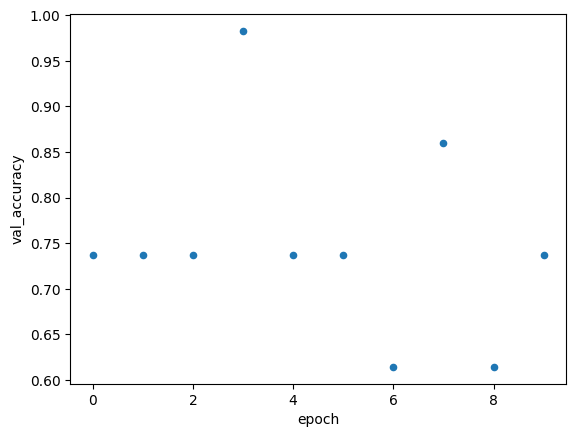

In [ ]:
import pandas as pd

epoch_data = pd.DataFrame.from_dict(resultado, orient='columns')

print(epoch_data)

epoch_data.plot.scatter(x='epoch',y='val_accuracy')

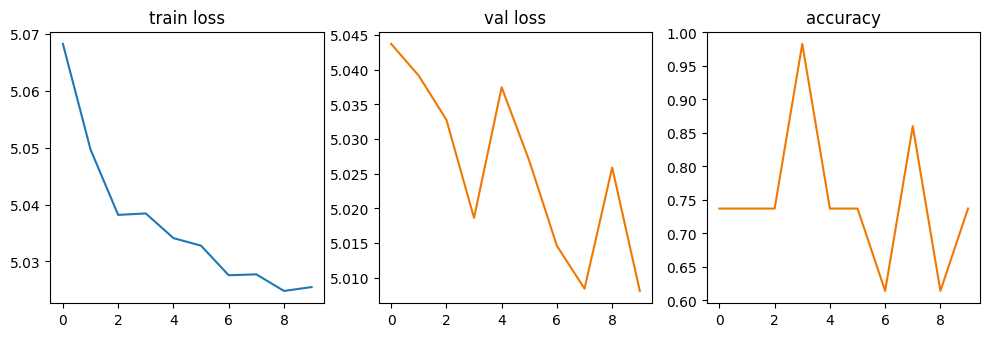

In [ ]:
import matplotlib.pyplot as plt

epochs = [res['epoch'] for res in resultado]
train_losses = [res['train_loss'] for res in resultado]
val_losses = [res['val_loss'] for res in resultado]
val_accuracy = [res['val_accuracy'] for res in resultado]

plt.figure(figsize = (12,12))
plt.subplot(3,3,1)
plt.title('train loss')
plt.plot(epochs,train_losses,label='train losss')

plt.subplot(3,3,2)
plt.title('val loss')
plt.plot(epochs,val_losses,label='val loss',  color = '#f07800')

plt.subplot(3,3,3)
plt.title('accuracy')
plt.plot(epochs,val_accuracy,label='val loss',  color = '#f07800')
plt.show()

## Code to save the trained model and training info to a file

In [ ]:
torch.save(model.state_dict(), 'modelSwin.pth')

## Code to save the dictionary info into a CSV file

In [ ]:
import csv

# Specify the file name
filename = 'training_results.csv'

# Ensure that the resultado list is not empty
if resultado:
    # Get the keys from the first dictionary as column headers
    keys = resultado[0].keys()

    # Open the file in write mode
    with open(filename, 'w', newline='') as csvfile:
        # Create a DictWriter object
        dict_writer = csv.DictWriter(csvfile, fieldnames=keys)

        # Write the header
        dict_writer.writeheader()

        # Write the rows
        dict_writer.writerows(resultado)


## Teste de classificação

In [2]:
!pwd

/content


In [19]:
model = swin_t(weights=None)

# Adjust the final layer to match the number of classes in your checkpoint
num_classes = 150
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Load the pre-trained model weights from your .pth file
model_weights_path = '/content/modelSwin.pth'
state_dict = torch.load(model_weights_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Now the model is ready to be used
print(model)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

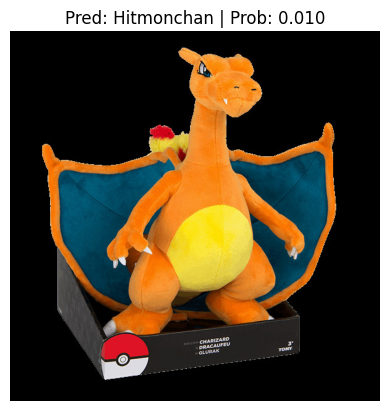

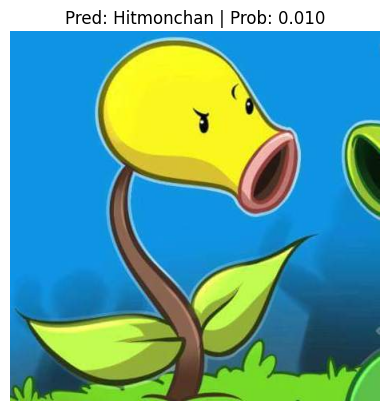

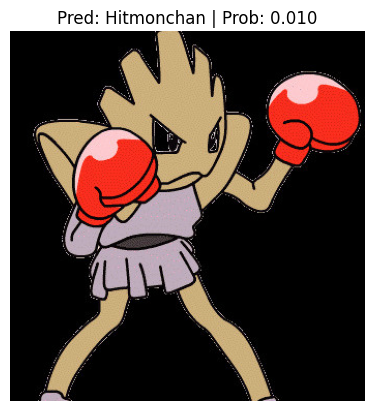

In [22]:
from predictions import pred_and_plot_image

# Setup custom image path
image_path1 = "/content/47688c25424b4cd795cf49873f9d2a01.jpg"
image_path2 = "/content/75a378a17572443c9b9e1893a537117a.jpg"
image_path3 = "/content/0dc5b9824263448ba866c4a3dae2ac33.jpg"
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=image_path1,
                    class_names=class_names)

pred_and_plot_image(model=model,
                    image_path=image_path2,
                    class_names=class_names)

pred_and_plot_image(model=model,
                    image_path=image_path3,
                    class_names=class_names)

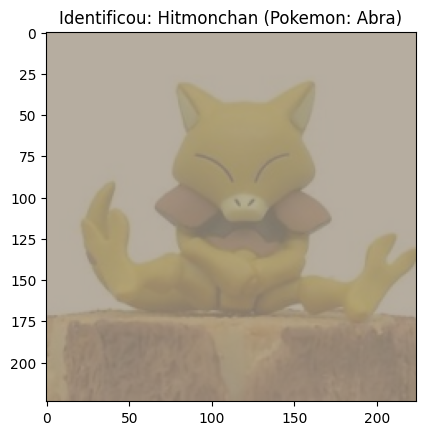

Identificação está incorreta.


In [28]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"

# Função para mostrar uma imagem
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause to update plots

# Selecionar uma imagem aleatória do conjunto de teste
def get_random_test_image(dataloader):
    images, labels = next(iter(dataloader))
    idx = random.randint(0, len(images) - 1)
    return images[idx], labels[idx]

# Testar o modelo com uma imagem de teste
def test_random_image(model, dataloader, class_names):
    model.eval()
    with torch.no_grad():
        image, label = get_random_test_image(dataloader)
        input_image = image.unsqueeze(0).to(device)
        label = label.to(device)

        outputs = model(input_image)
        _, preds = torch.max(outputs, 1)

        imshow(image.cpu(), title=f'Identificou: {class_names[preds[0]]} (Pokemon: {class_names[label]})')
        if preds[0] == label:
            print("Identificação está correta!")
        else:
            print("Identificação está incorreta.")

# Testar o modelo com uma imagem aleatória do conjunto de teste
test_random_image(model, test_loader, class_names)